<center><div style="direction:rtl;font-family:B Lotus, B Nazanin, Tahoma">به نام خدا</div></center>

<h1><center><div style="direction:rtl;font-family:B Lotus, B Nazanin, Tahoma">رگرسیون تخمین قیمت خانه با چند ورودی<br>تصویر+داده های ساختار یافته
</div></center></h1>

In [3]:
# import the necessary packages
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import glob
import cv2
import os
import locale

In [4]:
!git clone https://github.com/emanhamed/Houses-dataset.git

Cloning into 'Houses-dataset'...
remote: Enumerating objects: 2166, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 2166 (delta 0), reused 0 (delta 0), pack-reused 2165
Receiving objects: 100% (2166/2166), 176.26 MiB | 39.63 MiB/s, done.
Resolving deltas: 100% (20/20), done.


In [5]:
inputPath = "/content/Houses-dataset/Houses Dataset/HousesInfo.txt"
datasetPath = "/content/Houses-dataset/Houses Dataset"

cols = ["bedrooms", "bathrooms", "area", "zipcode", "price"]
df = pd.read_csv(inputPath, sep=" ", header=None, names=cols)


zipcodes, counts = np.unique(df["zipcode"], return_counts=True)

# loop over each of the unique zip codes and their corresponding
# count
for (zipcode, count) in zip(zipcodes, counts):
    # the zip code counts for our housing dataset is *extremely*
    # unbalanced (some only having 1 or 2 houses per zip code)
    # so let's sanitize our data by removing any houses with less
    # than 25 houses per zip code
    if count < 25:
        idxs = df[df["zipcode"] == zipcode].index
        df.drop(idxs, inplace=True)

In [6]:
# initialize our images array (i.e., the house images themselves)
images = []

# loop over the indexes of the houses
for i in df.index.values:
    # find the four images for the house and sort the file paths,
    # ensuring the four are always in the *same order*
    basePath = os.path.sep.join([datasetPath, "{}_*".format(i + 1)])
    housePaths = sorted(list(glob.glob(basePath)))
    # initialize our list of input images along with the output image
    # after *combining* the four input images
    inputImages = []
    outputImage = np.zeros((64, 64, 3), dtype="uint8")

    # loop over the input house paths
    for housePath in housePaths:
        # load the input image, resize it to be 32 32, and then
        # update the list of input images
        image = cv2.imread(housePath)
        image = cv2.resize(image, (32, 32))
        inputImages.append(image)

    # tile the four input images in the output image such the first
    # image goes in the top-right corner, the second image in the
    # top-left corner, the third image in the bottom-right corner,
    # and the final image in the bottom-left corner
    outputImage[0:32, 0:32] = inputImages[0]
    outputImage[0:32, 32:64] = inputImages[1]
    outputImage[32:64, 32:64] = inputImages[2]
    outputImage[32:64, 0:32] = inputImages[3]

    # add the tiled image to our set of images the network will be
    # trained on
    images.append(outputImage)
images = np.array(images)

In [7]:
images = images / 255.0

In [8]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
split = train_test_split(df, images, test_size=0.25, random_state=42)
(trainAttrX, testAttrX, trainImagesX, testImagesX) = split

In [9]:
# find the largest house price in the training set and use it to
# scale our house prices to the range [0, 1] (will lead to better
# training and convergence)
maxPrice = trainAttrX["price"].max()
trainY = trainAttrX["price"] / maxPrice
testY = testAttrX["price"] / maxPrice

In [10]:
# initialize the column names of the continuous data
continuous = ["bedrooms", "bathrooms", "area"]

# performin min-max scaling each continuous feature column to
# the range [0, 1]
cs = MinMaxScaler()
trainContinuous = cs.fit_transform(trainAttrX[continuous])
testContinuous = cs.transform(testAttrX[continuous])

# one-hot encode the zip code categorical data (by definition of
# one-hot encoing, all output features are now in the range [0, 1])
zipBinarizer = LabelBinarizer().fit(df["zipcode"])
trainCategorical = zipBinarizer.transform(trainAttrX["zipcode"])
testCategorical = zipBinarizer.transform(testAttrX["zipcode"])

# construct our training and testing data points by concatenating
# the categorical features with the continuous features
trainAttrX = np.hstack([trainCategorical, trainContinuous])
testAttrX = np.hstack([testCategorical, testContinuous])

In [11]:
dim = trainAttrX.shape[1] #10

# define our MLP network
mlp = Sequential()
mlp.add(Dense(8, input_dim=dim, activation="relu"))
mlp.add(Dense(4, activation="relu"))


In [14]:
from keras import Model, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dense, Flatten, Dropout
from keras.layers import BatchNormalization

width, height, depth = 64, 64, 3
filters=(16, 32, 64)
# initialize the input shape and channel dimension, assuming
# TensorFlow/channels-last ordering
inputShape = (height, width, depth)

# define the model input
inputs = Input(shape=inputShape)

# loop over the number of filters
for (i, f) in enumerate(filters):
    # if this is the first CONV layer then set the input
    # appropriately
    if i == 0:
        x = inputs

    # CONV => RELU => BN => POOL
    x = Conv2D(f, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

# flatten the volume, then FC => RELU => BN => DROPOUT
x = Flatten()(x)
x = Dense(16)(x)
x = Activation("relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# apply another FC layer, this one to match the number of nodes
# coming out of the MLP
x = Dense(4)(x)
x = Activation("relu")(x)

# construct the CNN
cnn = Model(inputs, x)

In [15]:
from keras.layers import concatenate
# create the input to our final set of layers as the *output* of both
# the MLP and CNN
combinedInput = concatenate([mlp.output, cnn.output])

# our final FC layer head will have two dense layers, the final one
# being our regression head
x = Dense(4, activation="relu")(combinedInput)
x = Dense(1, activation="linear")(x)

model = Model([mlp.input, cnn.input], x)

In [16]:
model.compile(loss="mean_absolute_percentage_error", optimizer='adam')


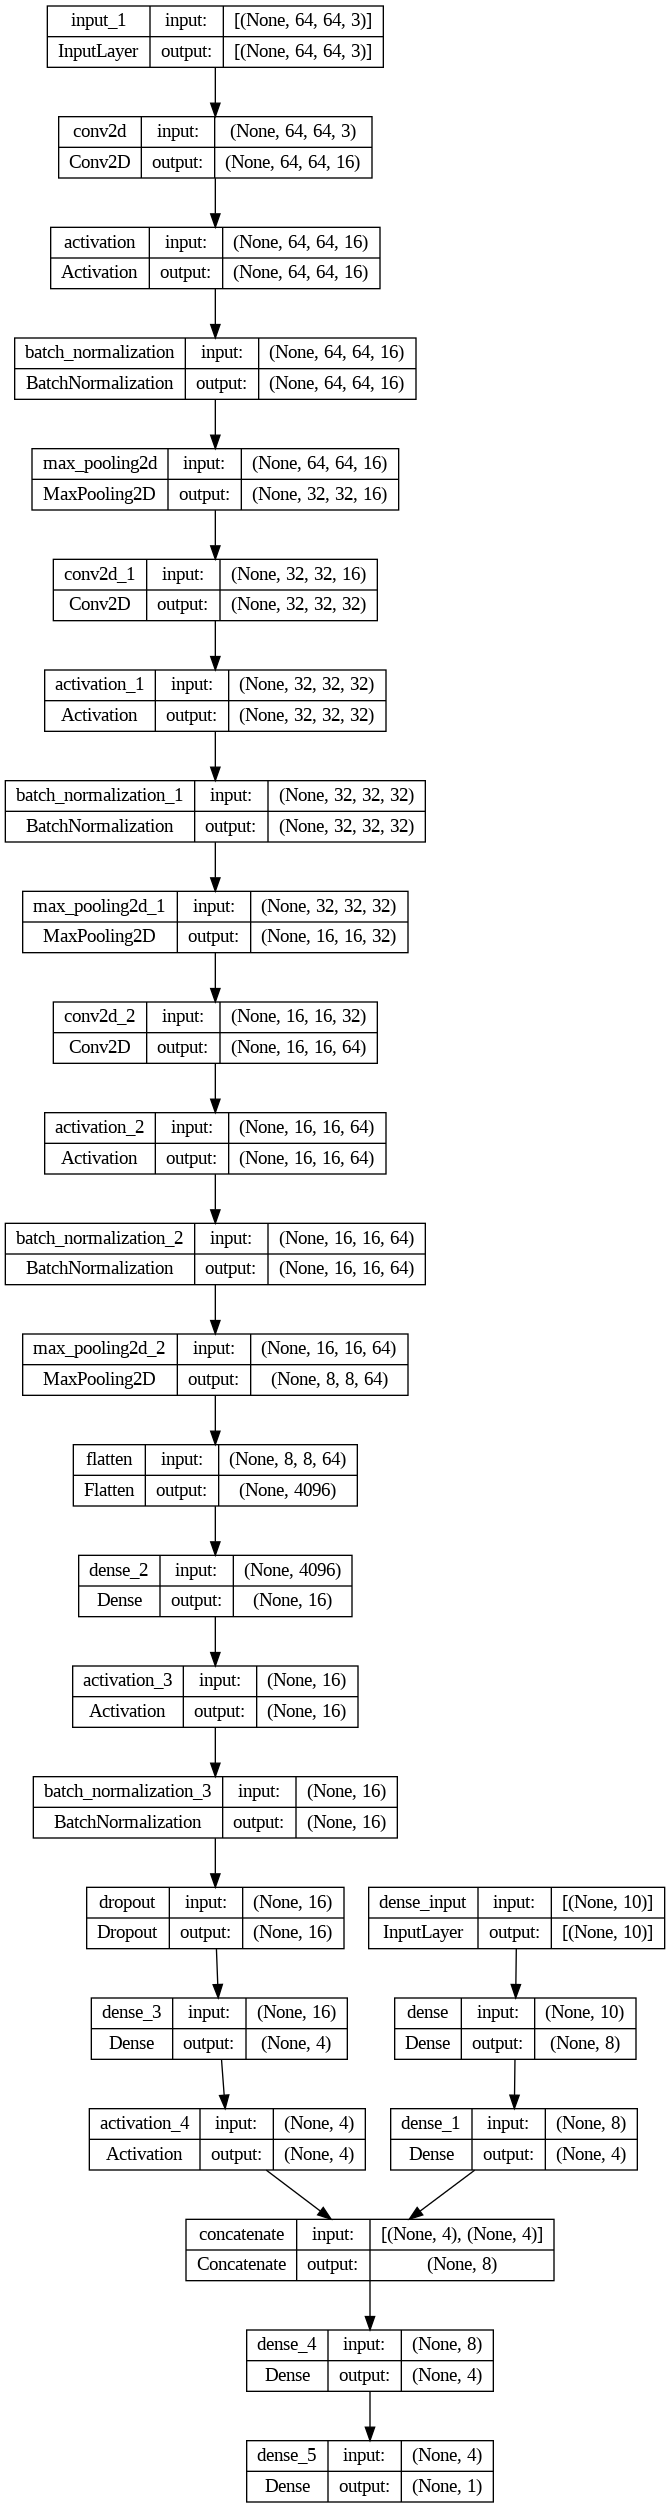

In [17]:
keras.utils.plot_model(model, show_shapes=True)

In [18]:
# train the model
model.fit(
    [trainAttrX, trainImagesX], trainY,
    validation_data=([testAttrX, testImagesX], testY),
    epochs=200, batch_size=8)

Epoch 1/200
34/34 [==============================] - 11s 30ms/step - loss: 759.4681 - val_loss: 134.1451
Epoch 2/200
34/34 [==============================] - 0s 9ms/step - loss: 546.4421 - val_loss: 199.2525
Epoch 3/200
34/34 [==============================] - 0s 9ms/step - loss: 284.4490 - val_loss: 173.2220
Epoch 4/200
34/34 [==============================] - 0s 10ms/step - loss: 201.1896 - val_loss: 429.0146
Epoch 5/200
34/34 [==============================] - 0s 8ms/step - loss: 184.0648 - val_loss: 134.2630
Epoch 6/200
34/34 [==============================] - 0s 8ms/step - loss: 102.9666 - val_loss: 91.3656
Epoch 7/200
34/34 [==============================] - 0s 9ms/step - loss: 93.9478 - val_loss: 118.1558
Epoch 8/200
34/34 [==============================] - 0s 10ms/step - loss: 75.9619 - val_loss: 191.7193
Epoch 9/200
34/34 [==============================] - 0s 10ms/step - loss: 83.7375 - val_loss: 181.6886
Epoch 10/200
34/34 [==============================] - 0s 9ms/step - loss

In [19]:
# make predictions on the testing data
preds = model.predict([testAttrX, testImagesX])

3/3 [==============================] - 0s 71ms/step


In [20]:
# compute the difference between the *predicted* house prices and the
# *actual* house prices, then compute the percentage difference and
# the absolute percentage difference
diff = preds.flatten() - testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)

# compute the mean and standard deviation of the absolute percentage
# difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)

# finally, show some statistics on our model
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("[INFO] avg. house price: {}, std house price: {}".format(
    locale.currency(df["price"].mean(), grouping=True),
    locale.currency(df["price"].std(), grouping=True)))
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))

[INFO] avg. house price: $533,388.27, std house price: $493,403.08
[INFO] mean: 17.11%, std: 15.19%
